In [37]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import random_split
import torch.nn.functional as F
#import torch.optim as optim

import pandas as pd
import seaborn as sns


In [38]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)



trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

testvalset = torchvision.datasets.CIFAR10(root='./data/', train=False,
                                          download=False, transform=transform)

testset, valset = random_split(testvalset, [0.5, 0.5])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

print(len(trainset))
print(len(testset))
print(len(valset))

# print(len(dataset))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
50000
5000
5000


In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device = torch.device("cpu")
# torch.cuda.device_count()
# torch.cuda.get_device_name(0)


cuda:0


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [41]:


def calculate_accuracy(model, testloader):
    running_samples_total = 0
    correct_predictions_total = 0
        
    for indx, data in enumerate(testloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        prediction = model(inputs)
        _, tensor_index = torch.max(prediction, dim=1)

        
        correct_predictions_total += (len(labels[labels==tensor_index]))
        running_samples_total += prediction.shape[0]
        
        #if (indx >= 2):
        #    break

    #print (correct_predictions_total)
    #print(f"#Samples: {running_samples_total}     #Correct Predctions: {correct_predictions_total}      Accuracy:{correct_predictions_total/running_samples_total}")

    return correct_predictions_total/running_samples_total


In [42]:
class Blur(nn.Module):
    def __init__(self):
        super(Blur, self).__init__()
        self.layers = torch.nn.Sequential(
            nn.MaxPool2d(4)
        )

    def forward(self,x):
       x = self.layers(x)
       #print(x.shape)
       x = F.interpolate(x, size=(32, 32), mode='nearest')
       return x


def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  #plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  #plt.show()

im, label = trainset[0]

effect = Blur()
#imshow(im)
im = torch.unsqueeze(im, 0)


blurredim = effect(im)
#print(blurredim.shape)
#imshow(torch.squeeze(blurredim))


In [47]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.00)

class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.InputDropout = nn.Dropout(p=0.2)

        self.ConvBlock1 = torch.nn.Sequential(
            nn.Conv2d(3, 96, 3, padding=1),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        self.ConvBlock2 =  torch.nn.Sequential(
            nn.Conv2d(96, 96, 3,padding=1),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.PoolBlock1 = torch.nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=2),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
        )

        self.ConvBlock3 = torch.nn.Sequential(
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.ConvBlock4 = torch.nn.Sequential(
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        self.PoolBlock2 = torch.nn.Sequential(
            nn.Conv2d(192, 192, 3, stride=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
        )

        self.ConvBlock5 = torch.nn.Sequential(
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.Dropout(),
        )

        self.LinLayer1 = torch.nn.Sequential(
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
        )

        self.LinLayer2 = torch.nn.Sequential(
            nn.Conv2d(192, 10, 1),
            nn.BatchNorm2d(num_features=10),
            nn.ReLU(),
        )

        self.FinalPool = nn.AvgPool2d(7)


        self.ConvLayers = torch.nn.Sequential(
            nn.Dropout(p=0.2),

            nn.Conv2d(3, 96, 3, padding=1),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.Dropout(),

            nn.Conv2d(96, 96, 3,padding=1),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),
            nn.Dropout(),

            ##Pool Block 1
            nn.Conv2d(96, 96, 3, stride=2),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(),

            ##Conv Block 3
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.Dropout(),

            ##Conv Block 4
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.Dropout(),

            ##Pool Block 2
            nn.Conv2d(192, 192, 3, stride=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),

            ##Conv Block 5
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.Dropout(),

            ##Lin Layer1
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),

            #Lin Layer 2
            nn.Conv2d(192, 10, 1),
            nn.BatchNorm2d(num_features=10),
            nn.ReLU(),

            ## Final Pool
            nn.AvgPool2d(7),

        )

    def forward(self, x):
        #x = self.ConvLayers(x)
        #x = torch.squeeze(x)

        # return x

        x = self.InputDropout(x)

        x = self.ConvBlock1(x)
        x = self.ConvBlock2(x)
        
        x = self.PoolBlock1(x)

        x = self.ConvBlock3(x)
        x = self.ConvBlock4(x)

        x = self.PoolBlock2(x)

        x = self.ConvBlock5(x)

        x = self.LinLayer1(x)
        x = self.LinLayer2(x)

        x = self.FinalPool(x)

        x = torch.squeeze(x)

        return x
    
    

model = CNN().to(device)
model.apply(init_weights)
print("bruh")

bruh


In [48]:
print_output_shape = False


data_iter = iter(trainset)

for i in range(3):
    (data, label) = next(data_iter)
im = data
data = data.unsqueeze(0)
input_shape = data.shape

if (print_output_shape):
    print(data.shape)
    print(model(data))
    print('\n')


from torchsummary import summary
_ = summary(model, ( 3, 32, 32))

#print(model(data).shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Dropout: 1-1                           [-1, 3, 32, 32]           --
├─Sequential: 1-2                        [-1, 96, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 96, 32, 32]          2,688
|    └─BatchNorm2d: 2-2                  [-1, 96, 32, 32]          192
|    └─ReLU: 2-3                         [-1, 96, 32, 32]          --
|    └─Dropout: 2-4                      [-1, 96, 32, 32]          --
├─Sequential: 1-3                        [-1, 96, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 96, 32, 32]          83,040
|    └─BatchNorm2d: 2-6                  [-1, 96, 32, 32]          192
|    └─ReLU: 2-7                         [-1, 96, 32, 32]          --
|    └─Dropout: 2-8                      [-1, 96, 32, 32]          --
├─Sequential: 1-4                        [-1, 96, 15, 15]          --
|    └─Conv2d: 2-9                       [-1, 96, 15, 15]          83,040
| 

In [49]:
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.97)


In [51]:
epoch_number = 100




epoch_list = []
minibatch_number_list = []
loss_list = []

val_accuracy_list = []
epoch_range_list = list(range(epoch_number))


for epoch in range(epoch_number):  # loop over the dataset multiple times

    running_loss = 0.0


    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
       
        outputs = model(inputs)
        #print(outputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 40 mini-batches
            epoch_list.append(epoch+1)
            minibatch_number_list.append(i+1)
            loss_list.append(running_loss/40)

            
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.7f}')
            running_loss = 0.0
            #print(scheduler.get_last_lr())


    scheduler.step()

    val_accuracy_list.append(calculate_accuracy(model, valloader))


print('Finished Training')

[1,    40] loss: 1.7737041
[1,    80] loss: 1.7518730
[1,   120] loss: 1.7034495
[1,   160] loss: 1.6548545
[1,   200] loss: 1.6548720
[1,   240] loss: 1.6016446
[1,   280] loss: 1.5715270
[1,   320] loss: 1.5376061
[1,   360] loss: 1.5071645
[2,    40] loss: 1.4659912
[2,    80] loss: 1.4225943
[2,   120] loss: 1.4054956
[2,   160] loss: 1.4075670
[2,   200] loss: 1.3803695
[2,   240] loss: 1.3480021
[2,   280] loss: 1.3223747
[2,   320] loss: 1.3177091
[2,   360] loss: 1.2902499
[3,    40] loss: 1.2537896
[3,    80] loss: 1.2209797
[3,   120] loss: 1.2259443
[3,   160] loss: 1.2076348
[3,   200] loss: 1.2284263
[3,   240] loss: 1.2176170
[3,   280] loss: 1.1821564
[3,   320] loss: 1.1767497
[3,   360] loss: 1.1778306
[4,    40] loss: 1.1429027
[4,    80] loss: 1.1420553
[4,   120] loss: 1.1284429
[4,   160] loss: 1.0856263
[4,   200] loss: 1.0923059
[4,   240] loss: 1.0724507
[4,   280] loss: 1.0874588
[4,   320] loss: 1.0795594
[4,   360] loss: 1.0709360
[5,    40] loss: 1.0264477
[

Text(0.5, 1.0, 'Training Loss')

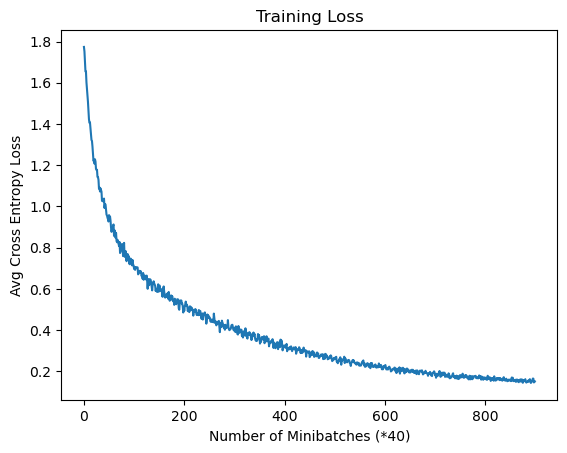

In [52]:
dic = {'losses':loss_list, 'epoch':epoch_list, "batch":minibatch_number_list}
df = pd.DataFrame(data=dic)
#df = df[150:]

p = sns.lineplot(data=df, x=df.index, y='losses')
p.set_xlabel("Number of Minibatches (*40)")
p.set_ylabel("Avg Cross Entropy Loss")
p.set_title("Training Loss")


Text(0.5, 1.0, 'Test Accuracy per Epoch')

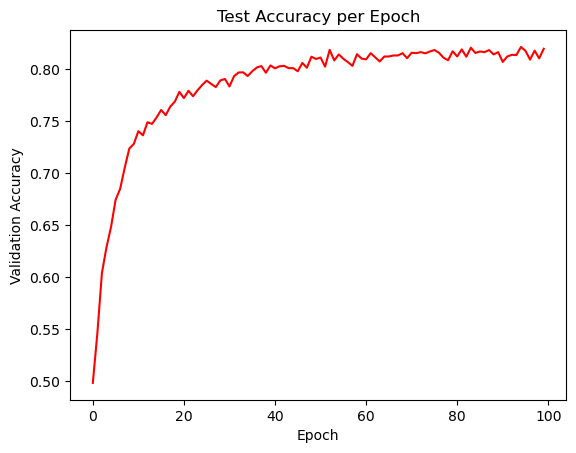

In [53]:
dic2 = {'Validation Accuracy':val_accuracy_list, 'Epoch':epoch_range_list}
df2 = pd.DataFrame(data=dic2)

p2 = sns.lineplot(data=df2, x='Epoch', y='Validation Accuracy', color='red')
p2.set_title('Test Accuracy per Epoch')

In [54]:
test_single_image = False

if (test_single_image):
    data_iter = iter(testset)

    for i in range(40):
        (data, label) = next(data_iter)
    im = data
    data = data.unsqueeze(0)
    soft = nn.Softmax(dim=1)
    imshow(im)
    print(label)

    model_output = model(data)
    prediction = soft(model_output)

    _, ind = (torch.max(prediction, dim=1))
    print(ind)
    print("\n")

#from torchviz import make_dot, make_dot_from_trace
#make_dot(model_output.mean(), params=dict(model.named_parameters()))




In [55]:

calculate_accuracy(model, testloader)


0.8236

### Code to save Model

In [56]:
#torch.save(model.state_dict(), "model_weights_trial11)